### Read in data

In [ ]:
library(edgeR)
# install.packages("reshape2")
#install.packages("tidyr")
library(reshape2)
#library(tidyverse)

#library(rstatix)
library(tidyr)
library(dplyr)
#library(ggpubr)
library(ggplot2)
library(EnhancedVolcano)
## Vulcano plot

 #if (!requireNamespace('BiocManager', quietly = TRUE))
  #  install.packages('BiocManager')

  #BiocManager::install('EnhancedVolcano')

Loading required package: limma


Attaching package: ‘tidyr’


The following object is masked from ‘package:reshape2’:

    smiths



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ggrepel



In [39]:
raw_counts = "/DKED/scratch/nadjafn/Atlantic_ASE/nf-potato-ase/results/04_ALLELECOUNTS/Synt_counts_all.tsv"
info = "/DKED/scratch/nadjafn/Atlantic_ASE/nf-potato-ase/results/04_ALLELECOUNTS/Synt_counts_with_info.tsv"

# read in tabel with raw counts
raw_counts = read.table(raw_counts, header = TRUE, sep = "\t")
# read in table with info
info = read.table(info, header = TRUE, sep = "\t")
# merge the two tables on the column "Synt_id"
raw_counts = merge(raw_counts, info, by = "Synt_id")
# set synt_id as rownames
rownames(raw_counts) = raw_counts$Synt_id
# remove the column "Synt_id"
raw_counts = raw_counts[,-1]
# replaace NA values with 0
raw_counts[is.na(raw_counts)] = 0
# filter the genes that have length_category == more_20%_difference and mulitmapping_tag = mulitmapping 
#raw_counts_filter = raw_counts[raw_counts$haplotype_with_longest_annotation == "equal_lengths" & raw_counts$multimapping_tag != "multimapping",]
raw_counts_filter = raw_counts[raw_counts$length_category != "more_20%_difference" & raw_counts$multimapping_tag != "multimapping",]
# get the sample columns starting with SRR
sample_columns = colnames(raw_counts_filter)[grep("SRR", colnames(raw_counts_filter))]
# only keeep the columns with the sample names
raw_counts_filter = raw_counts_filter[, sample_columns]
raw_counts = raw_counts[, sample_columns]
# Filter the counts to make sure that for each tissue they have at least 20 counts
leaf_samples = colnames(raw_counts_filter)[grep("leaf", colnames(raw_counts_filter))]
tuber_samples = colnames(raw_counts_filter)[grep("tuber", colnames(raw_counts_filter))]
raw_counts_filter = raw_counts_filter[rowSums(raw_counts_filter[,leaf_samples]) > 100 & rowSums(raw_counts_filter[,tuber_samples]) > 100,]
dim(raw_counts_filter)
# raw counts for synt 261
raw_counts_filter["261",]


[1] 331  40

,SRR14993892_leaf_1,SRR14993892_leaf_2,SRR14993892_leaf_3,SRR14993892_leaf_4,SRR14993893_leaf_1,SRR14993893_leaf_2,SRR14993893_leaf_3,SRR14993893_leaf_4,SRR14993894_leaf_1,SRR14993894_leaf_2,⋯,SRR14995034_tuber_3,SRR14995034_tuber_4,SRR14995933_tuber_1,SRR14995933_tuber_2,SRR14995933_tuber_3,SRR14995933_tuber_4,SRR14996168_leaf_1,SRR14996168_leaf_2,SRR14996168_leaf_3,SRR14996168_leaf_4
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
261,0,0,0,14,0,0,0,2,0,0,⋯,0,13,48,0,0,20,0,0,0,57


### Compare Unfiltered and filtered data

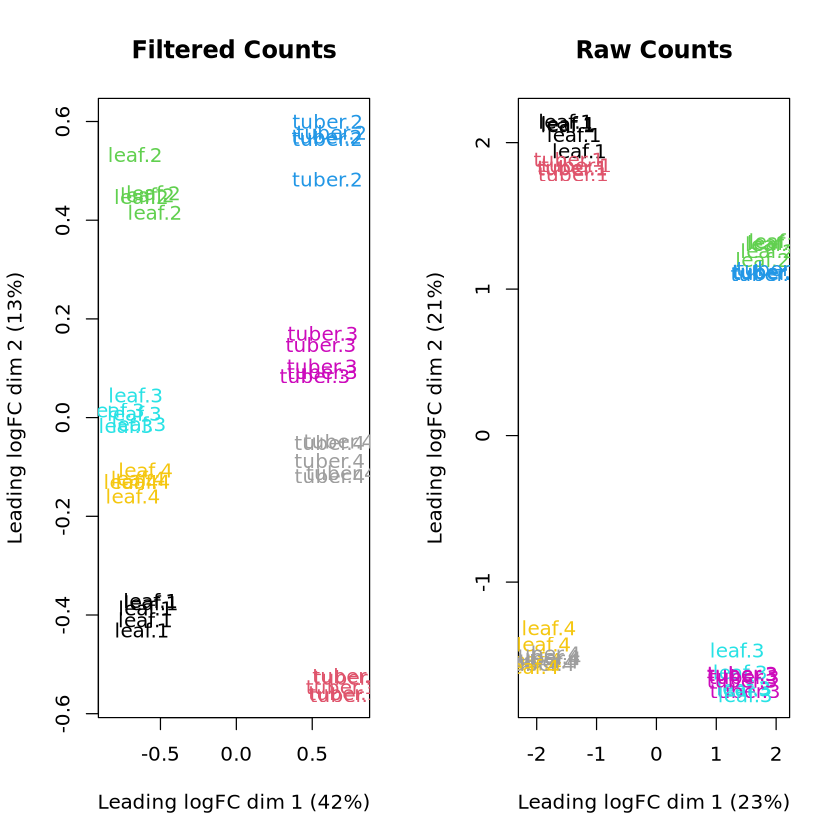

In [43]:
# Set up plotting layout: 1 row and 2 columns
par(mfrow = c(1, 2))

# Loop through raw_counts_filter and raw_counts
for (counts in list(raw_counts_filter, raw_counts)) {
    # Create DGEList and calculate normalization factors
    d0 <- DGEList(counts)
    d0 <- calcNormFactors(d0)
    
    # Filter genes based on CPM values
    cutoff <- 1
    min_samples <- 2  # Minimum number of samples where the gene must exceed the cutoff
    cpm_values <- cpm(d0)
    keep <- rowSums(cpm_values >= cutoff) >= min_samples
    d <- d0[keep, ]
    dim(d)
    
    # Extract group information
    snames <- colnames(counts)
    split_parts <- strsplit(snames, "_")
    tissue <- sapply(split_parts, `[`, 2)
    allele <- sapply(split_parts, `[`, 3)
    group <- interaction(tissue, allele)
    
    # Plot MDS
    plotMDS(d, col = as.numeric(group), labels = group, main = ifelse(identical(counts, raw_counts_filter), "Filtered Counts", "Raw Counts"))
}


### Filtered data

Is the allelic ratio between tuber and leave different for one allele?

### T-test


In [44]:
# Extract `_1` samples from snames
samples_1 <- snames[grep("_1$", snames)]
raw_counts_filter_ratio <- raw_counts_filter
# Calculate the ratios for each `_1` sample
for (sample in samples_1) {
  # Get the corresponding group (all related samples for the same condition)
  group <- snames[grep(gsub("_1$", "", sample), snames)]
  
  # Calculate the ratio for the `_1` sample
  ratio_col <- paste0(sample, "_ratio")
  
  # Compute the ratio and add it to the data
  raw_counts_filter_ratio[[ratio_col]] <- raw_counts_filter_ratio[[sample]] / 
    rowSums(raw_counts_filter_ratio[group])
}
# drop the columns that dont have the _ratio in the name
raw_counts_filter_ratio <- raw_counts_filter_ratio[,grep("_ratio", colnames(raw_counts_filter_ratio))]
# View the resulting DataFrame

# drop the columns that have NA values in any column

raw_counts_filter_ratio <- raw_counts_filter_ratio[complete.cases(raw_counts_filter_ratio), ]

No id variables; using all as measure variables



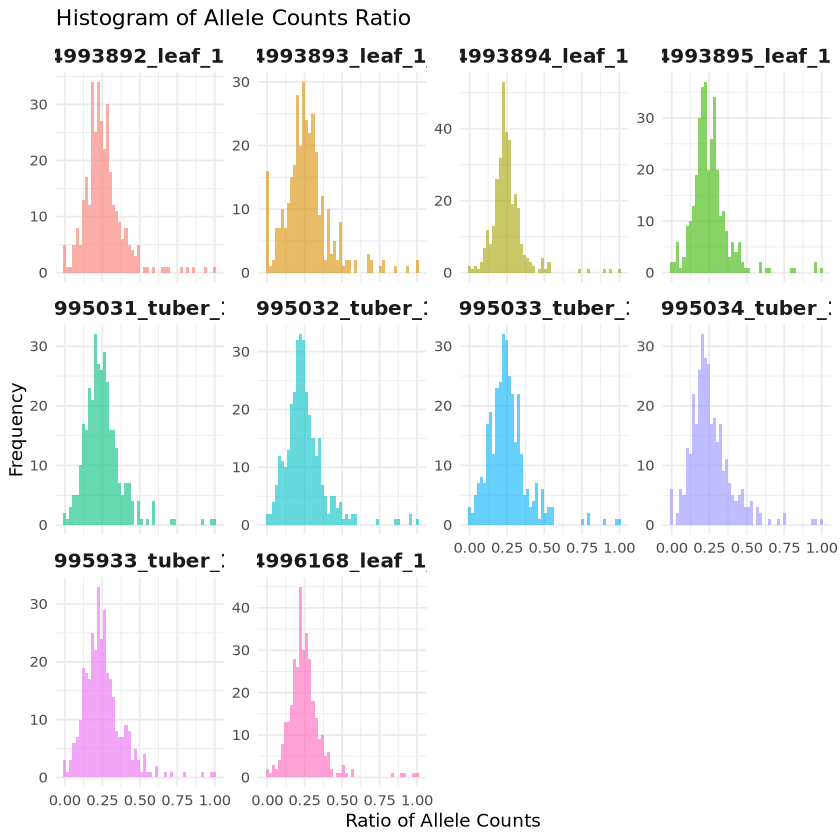

In [45]:
# melt the data
raw_counts_filter_ratio_melt = melt(raw_counts_filter_ratio)
# make a histogram of the values a histogram per variable in one plot
ggplot(raw_counts_filter_ratio_melt, aes(x = value, fill = variable)) +
  geom_histogram(bins = 50, alpha = 0.6) +
  labs(
    title = "Histogram of Allele Counts Ratio",
    x = "Ratio of Allele Counts",
    y = "Frequency"
  ) +
  facet_wrap(~variable, scales = "free_y") +
  theme_minimal() +
  theme(
    legend.position = "none",
    strip.text = element_text(size = 12, face = "bold")
  )

In [46]:
# pivot the data
raw_counts_filter_ratio$Synt_id <- rownames(raw_counts_filter_ratio)
raw_counts_filter_ratio_pivot <- reshape2::melt(raw_counts_filter_ratio, id.vars = "Synt_id")
# add the tissue 
# Ensure the variable column is a character vector
raw_counts_filter_ratio_pivot$variable <- as.character(raw_counts_filter_ratio_pivot$variable)

# Extract the second element after splitting by "_"
raw_counts_filter_ratio_pivot$tissue <- sapply(strsplit(raw_counts_filter_ratio_pivot$variable, "_"), `[`, 2)
raw_counts_filter_ratio_pivot$tissue  <- as.factor(raw_counts_filter_ratio_pivot$tissue )




	Welch Two Sample t-test

data:  value by tissue
t = -3.3894, df = 4.4511, p-value = 0.02333
alternative hypothesis: true difference in means between group leaf and group tuber is not equal to 0
95 percent confidence interval:
 -0.22993733 -0.02734612
sample estimates:
 mean in group leaf mean in group tuber 
          0.1623738           0.2910156 


,Synt_id,X1,X2,X3,X4,num_reads_multi,multi_ratio,allele_ratio_hap1,allele_ratio_hap2,allele_ratio_hap3,allele_ratio_hap4,multimapping_tag,ref_length_1G,ref_length_2G,ref_length_3G,ref_length_4G,haplotype_id,length_category,haplotype_with_longest_annotation
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>
4013,6218,1030,1655,1914,1756,274,0.04311566,0.1620771,0.2604249,0.3011802,0.2763179,unique,1157,1171,1163,1162,Synt_13008_chr05_1G_x4|hap1_Soltu.DM.05G010700.2|Soltu.Atl_v3.05_1G010130Synt_13008_chr05_2G_x4|hap2_Soltu.DM.05G010700.2|Soltu.Atl_v3.05_2G009530Synt_13008_chr05_3G_x4|hap3_Soltu.DM.05G010700.2|Soltu.Atl_v3.05_3G009760Synt_13008_chr05_4G_x4|hap4_Soltu.DM.05G010700.2|Soltu.Atl_v3.05_4G007720,more_1%_difference,2G


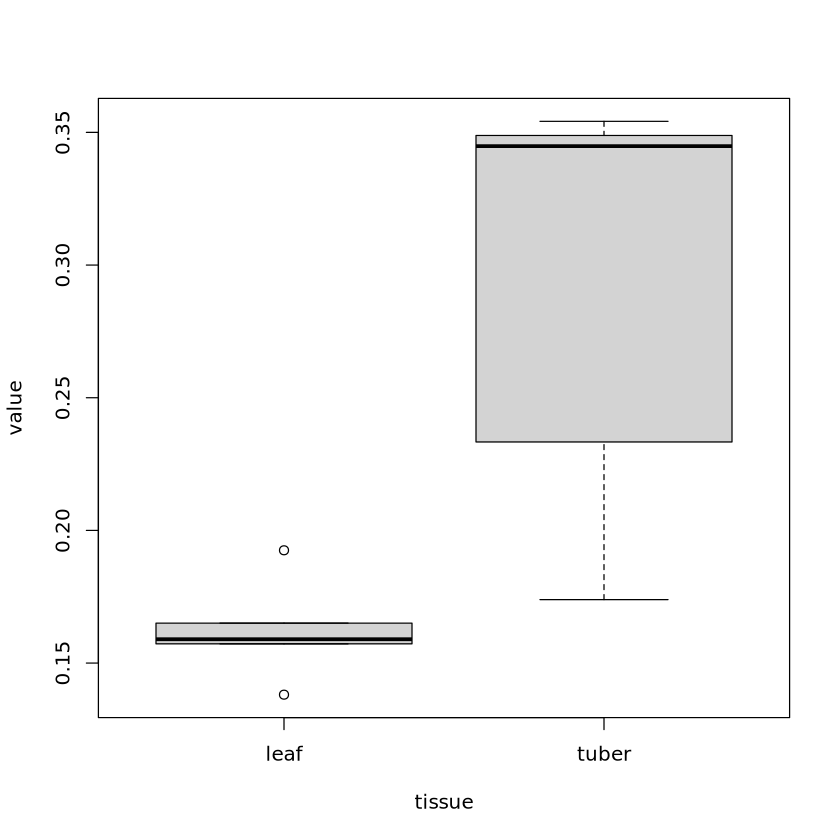

In [47]:
# print the rows for one synt id
test_data <- raw_counts_filter_ratio_pivot[raw_counts_filter_ratio_pivot$Synt_id == "6218",]
plot(value ~ tissue, data=test_data )
t.test(value ~ tissue, data=test_data)
# print the row name is 62

raw_counts_filter$Synt_id <- rownames(raw_counts_filter)
# print the row name is 62
raw_counts_plot <- raw_counts_filter[raw_counts_filter$Synt_id == "6218",]
# print the info for the synt id 62
info[info$Synt_id == "6218",]

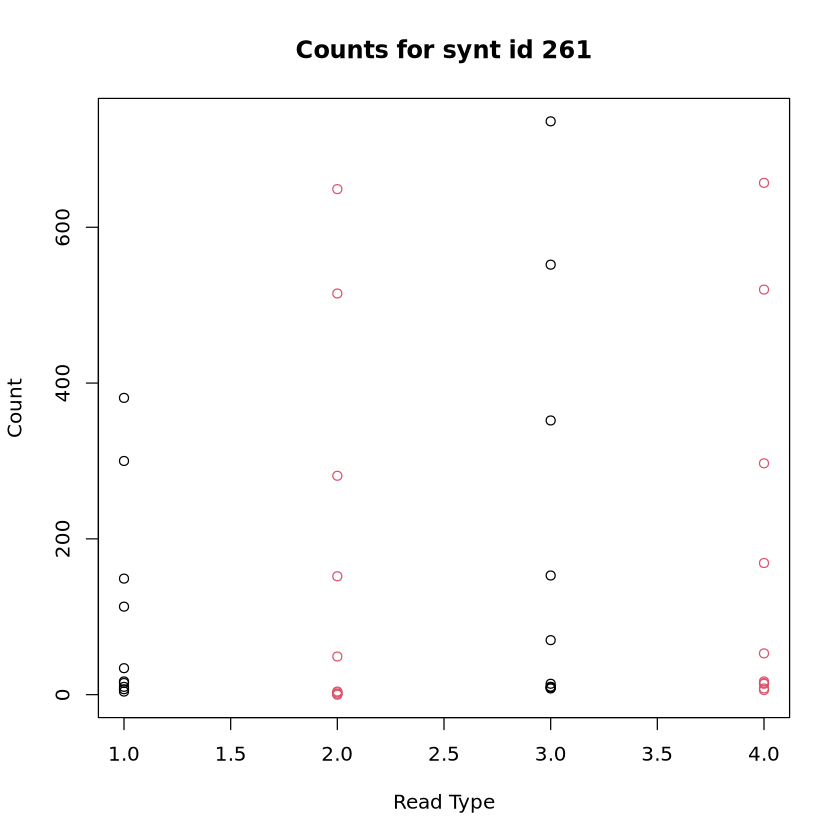

In [48]:
melted = melt(raw_counts_plot, id.vars = "Synt_id", variable.name = "Read_Type", value.name = "Count")
# make tissue and alleel as columns
melted$Read_Type <- as.character(melted$Read_Type)
melted$allele <- sapply(strsplit(melted$Read_Type, "_"), `[`, 3)
melted$tissue <- sapply(strsplit(melted$Read_Type, "_"), `[`, 2)


plot(melted$Count ~ melted$allele, data = melted, main = "Counts for synt id 261", xlab = "Read Type", ylab = "Count", col = factor(levels(factor(melted$tissue))))

In [49]:
# Get the unique Synt_id values
synt_ids <- unique(raw_counts_filter_ratio_pivot$Synt_id)

# Initialize a list to store t-test results
t_test_results <- list()

# Loop through each Synt_id and perform the t-test
for (synt_id in synt_ids) {
  # Filter data for the current Synt_id
  test_data <- raw_counts_filter_ratio_pivot[raw_counts_filter_ratio_pivot$Synt_id == synt_id, ]
  
  # Ensure there are at least two groups for the t-test
  if (length(unique(test_data$tissue)) > 1) {
    # Perform the t-test with error handling
    t_test_result <- tryCatch({
      t.test(value ~ tissue, data = test_data)
    }, error = function(e) {
      # Return a custom error message if t.test fails
      list(error = TRUE, message = e$message)
    })
    
    # Check if t.test was successful or returned an error
    if (!is.list(t_test_result) || is.null(t_test_result$error)) {
      # Store the successful t-test results
      t_test_results[[synt_id]] <- data.frame(
        Synt_id = synt_id,
        p_value = t_test_result$p.value,
        statistic = t_test_result$statistic,
        conf_int_lower = t_test_result$conf.int[1],
        conf_int_upper = t_test_result$conf.int[2],
        mean_leaf = mean(test_data$value[test_data$tissue == "leaf"], na.rm = TRUE),
        mean_tuber = mean(test_data$value[test_data$tissue == "tuber"], na.rm = TRUE),
        message = NA
      )
    } else {
      # Handle the error case
      t_test_results[[synt_id]] <- data.frame(
        Synt_id = synt_id,
        p_value = NA,
        statistic = NA,
        conf_int_lower = NA,
        conf_int_upper = NA,
        mean_leaf = NA,
        mean_tuber = NA,
        message = t_test_result$message
      )
    }
  }
}

# Combine all results into a single data frame
t_test_summary <- do.call(rbind, t_test_results)

# View the summary where the p value is less than 0.05
t_test_summary <- t_test_summary[t_test_summary$p_value < 0.0005, ]

print(t_test_summary)
dim(t_test_summary)

# Optionally, write the summary to a CSV file
#write.csv(t_test_summary, "t_test_summary.csv", row.names = FALSE)


      Synt_id      p_value  statistic conf_int_lower conf_int_upper  mean_leaf
261       261 9.395534e-06 -28.209804    -0.84766437    -0.69575869 0.00000000
NA       <NA>           NA         NA             NA             NA         NA
1648     1648 1.421620e-04   9.903231     0.13247514     0.22387391 0.34725906
1885     1885 1.120525e-06  13.069252     0.61881965     0.88400706 0.89529388
2518     2518 4.589939e-05  10.490725     0.07666249     0.12339807 0.11265300
2900     2900 2.253893e-05  -8.777528    -0.24108832    -0.14074129 0.30423827
2989     2989 3.303973e-04   5.994696     0.07922704     0.17839659 0.25385957
3014     3014 4.679266e-04  -5.804419    -0.11459138    -0.04909674 0.25486881
4228     4228 1.052091e-06 -13.273082    -0.20978167    -0.14761758 0.29540059
4332     4332 1.135171e-04  -7.070935    -0.28412278    -0.14408013 0.07247899
4848     4848 1.731662e-04   7.346124     0.04206450     0.08225190 0.35386191
5189     5189 4.592464e-05   8.359348     0.06436416

[1] 19  8

### Beta-Bionomial test

In [12]:

library(countdata)


Sum the count within each sample

In [13]:
# Extract `_1` samples from snames
samples_1 <- snames[grep("_1$", snames)]
raw_counts_filter_bionom <- raw_counts_filter
# Calculate the ratios for each `_1` sample
for (sample in samples_1) {
  # Get the corresponding group (all related samples for the same condition)
  group <- snames[grep(gsub("_1$", "", sample), snames)]
  # Calculate the ratio for the `_1` sample
  sum_col <- paste0(sample, "_sum")
  
  # Compute the ratio and add it to the data
  raw_counts_filter_bionom[[sum_col]] <-  rowSums(raw_counts_filter_bionom[group])
}
# drop the columns that dont have the _ratio in the name
#raw_counts_filter_bionom <- raw_counts_filter_bionom[,grep("_sum", colnames(raw_counts_filter_bionom))]
# View the resulting DataFrame

# drop the columns that have NA values in any column

raw_counts_filter_bionom <- raw_counts_filter_bionom[complete.cases(raw_counts_filter_bionom), ]
raw_counts_filter_bionom <- raw_counts_filter_bionom[,grep("_1", colnames(raw_counts_filter_bionom))]



#### Pivot table

In [35]:
library(stringr)
library(tidyr)
# pivot the data
raw_counts_filter_bionom$Synt_id <- rownames(raw_counts_filter_bionom)
# get the columns that have the _sum in the name

# Identify column names containing "_sum"
sum_columns <- colnames(raw_counts_filter_bionom)[str_detect(colnames(raw_counts_filter_bionom), "_sum")]
# Identify column names NOT containing "_sum"
not_sum_columns <- colnames(raw_counts_filter_bionom)[
  !str_detect(colnames(raw_counts_filter_bionom), "_sum") & 
  !str_detect(colnames(raw_counts_filter_bionom), "Synt")
]


# Gather the data into long format
melted_table <- raw_counts_filter_bionom %>%
  pivot_longer(
    cols = starts_with("SRR"),
    names_to = "variable",
    values_to = "value"
  )

print(melted_table)

# Separate into two columns based on _sum and not _sum
reshaped_table <- melted_table %>%
  mutate(
    base_variable = str_remove(variable, "_sum"),
    group = ifelse(str_detect(variable, "_sum"), "sum", "not_sum")
   ) 

pivoted = pivot_wider(reshaped_table, names_from = group, values_from = value)
# drop the varialbe column

# Collapse _sum and not_sum values into a single column
collapsed_table <- pivoted %>%
  group_by(Synt_id, base_variable) %>%
  summarize(
    allele_1 = sum(not_sum, na.rm = TRUE),
    sum_allele = sum(sum, na.rm = TRUE),
    .groups = "drop"
  )

# View the result

# add tissue info
# Ensure the variable column is a character vector
collapsed_table$base_variable <- as.character(collapsed_table$base_variable)
# Extract the second element after splitting by "_"
collapsed_table$tissue <- sapply(strsplit(collapsed_table$base_variable, "_"), `[`, 2)
collapsed_table$ratio <- collapsed_table$allele_1 / collapsed_table$sum_allele
# plot the ratio per synt id
# color where synt id is  "261" 



# A tibble: 6,620 × 3
   Synt_id variable            value
   <chr>   <chr>               <dbl>
 1 114     SRR14993892_leaf_1     38
 2 114     SRR14993893_leaf_1     21
 3 114     SRR14993894_leaf_1    204
 4 114     SRR14993895_leaf_1     88
 5 114     SRR14995031_tuber_1    46
 6 114     SRR14995032_tuber_1    45
 7 114     SRR14995033_tuber_1    68
 8 114     SRR14995034_tuber_1    29
 9 114     SRR14995933_tuber_1    39
10 114     SRR14996168_leaf_1    153
# ℹ 6,610 more rows


In [25]:
# Split the data by unique Synt_id values
split_data <- split(collapsed_table, collapsed_table$Synt_id)

# Use lapply to perform the operation on each subset and collect results
results_list <- lapply(names(split_data), function(synt_id) {
  test_data <- split_data[[synt_id]]
  
  # Drop the rows where sum_allele is 0
  test_data <- test_data[test_data$sum_allele != 0, ]
  
  # Check if there's enough data to perform the test
  if (nrow(test_data) < 2) {
    return(data.frame(
      Synt_id = synt_id,
      p_value = NA,
      mean_group1 = NA,
      mean_group2 = NA,
      log_fold_change = NA
    ))
  }
  
  # Perform the Binomial test
  test_result <- bb.test(
    x = test_data$allele_1,
    tx = test_data$sum_allele,
    group = test_data$tissue,
    n.threads = 10
  )
  
  # Calculate the means for the two groups
  group_means <- aggregate(
    cbind(allele_1, sum_allele) ~ tissue,
    data = test_data,
    FUN = sum
  )
  group_means$mean <- group_means$allele_1 / group_means$sum_allele
  
  # Ensure there are exactly two groups
  if (nrow(group_means) != 2) {
    return(data.frame(
      Synt_id = synt_id,
      p_value = NA,
      mean_group1 = NA,
      mean_group2 = NA,
      log_fold_change = NA
    ))
  }
  
  # Calculate log fold change
  log_fold_change <- log2(group_means$mean[1] / group_means$mean[2])
  
  # Create a data frame with the results
  data.frame(
    Synt_id = synt_id,
    p_value = test_result$p.value,
    mean_group1 = group_means$mean[1],
    mean_group2 = group_means$mean[2],
    log_fold_change = log_fold_change
  )
})

# Combine the list of data frames into a single data frame
results_df <- do.call(rbind, results_list)


Using a single CPU core ...
No. of data rows = 1, no. of groups = 2, no. of samples = 10.
100%
Done.
Using a single CPU core ...
No. of data rows = 1, no. of groups = 2, no. of samples = 10.
100%
Done.
Using a single CPU core ...
No. of data rows = 1, no. of groups = 2, no. of samples = 10.
100%
Done.
Using a single CPU core ...
No. of data rows = 1, no. of groups = 2, no. of samples = 10.
100%
Done.
Using a single CPU core ...
No. of data rows = 1, no. of groups = 2, no. of samples = 10.
100%
Done.
Using a single CPU core ...
No. of data rows = 1, no. of groups = 2, no. of samples = 10.
100%
Done.
Using a single CPU core ...
No. of data rows = 1, no. of groups = 2, no. of samples = 10.
100%
Done.
Using a single CPU core ...
No. of data rows = 1, no. of groups = 2, no. of samples = 10.
100%
Done.
Using a single CPU core ...
No. of data rows = 1, no. of groups = 2, no. of samples = 10.
100%
Done.
Using a single CPU core ...
No. of data rows = 1, no. of groups = 2, no. of samples = 10.
1

Synt_id,p_value,mean_group1,mean_group2,log_fold_change,p_adj
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


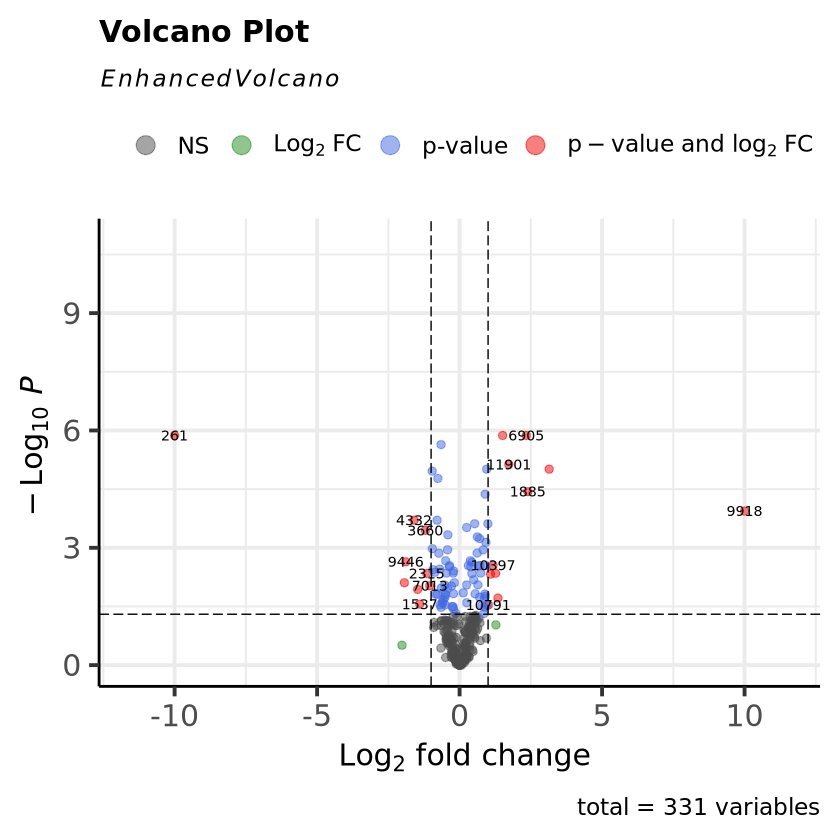

In [36]:
# Generate the volcano plot
# drop infinite log fold change values
results_df[is.infinite(results_df$log_fold_change),]
# if logFC is -Inf replace it with -10
results_df$log_fold_change[results_df$log_fold_change == -Inf] <- -5
# if logFC is Inf replace it with 10
results_df$log_fold_change[results_df$log_fold_change == Inf] <- 5
# adjust the p values
results_df$p_adj <- p.adjust(results_df$p_value, method="fdr") 

EnhancedVolcano(
  results_df,
  lab = results_df$Synt_id,
  # selectLab = c("261"),
  x = 'log_fold_change',
  y = 'p_adj',
  title = 'Volcano Plot',
  pCutoff = 0.05,
  FCcutoff = 1,
  pointSize = 2.0,
  labSize = 3.0
)

In [37]:
results_df[results_df$Synt_id == "1885",]
# plot info for synt id 9918
info %>% filter(Synt_id == "1885")

,Synt_id,p_value,mean_group1,mean_group2,log_fold_change,p_adj
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
86,1885,1.108308e-06,0.867052,0.1650485,2.393228,3.657416e-05


Synt_id,X1,X2,X3,X4,num_reads_multi,multi_ratio,allele_ratio_hap1,allele_ratio_hap2,allele_ratio_hap3,allele_ratio_hap4,multimapping_tag,ref_length_1G,ref_length_2G,ref_length_3G,ref_length_4G,haplotype_id,length_category,haplotype_with_longest_annotation
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>
1885,167,5,99,5,7,0.02536232,0.6050725,0.01811594,0.3586957,0.01811594,unique,965,1007,1017,1010,Synt_4469_chr02_1G_x4|hap1_Soltu.DM.02G009110.2|Soltu.Atl_v3.02_1G007980Synt_4469_chr02_2G_x4|hap2_Soltu.DM.02G009110.2|Soltu.Atl_v3.02_2G009370Synt_4469_chr02_3G_x4|hap3_Soltu.DM.02G009110.2|Soltu.Atl_v3.02_3G009230Synt_4469_chr02_4G_x4|hap4_Soltu.DM.02G009110.2|Soltu.Atl_v3.02_4G008890,more_5%_difference,3G


In [32]:
results_df[results_df$Synt_id == "6905",]
# plot info for synt id 9918
info %>% filter(Synt_id == "6905")

,Synt_id,p_value,mean_group1,mean_group2,log_fold_change
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
254,6905,4.763655e-09,0.3716814,0.07336343,2.340934


Synt_id,X1,X2,X3,X4,num_reads_multi,multi_ratio,allele_ratio_hap1,allele_ratio_hap2,allele_ratio_hap3,allele_ratio_hap4,multimapping_tag,ref_length_1G,ref_length_2G,ref_length_3G,ref_length_4G,haplotype_id,length_category,haplotype_with_longest_annotation
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>
6905,275,845,234,97,59,0.04066161,0.1895245,0.582357,0.1612681,0.06685045,unique,1134,1163,1156,1142,Synt_14201_chr05_1G_x4|hap1_Soltu.DM.05G025510.1|Soltu.Atl_v3.05_1G023730Synt_14201_chr05_2G_x4|hap2_Soltu.DM.05G025510.1|Soltu.Atl_v3.05_2G023530Synt_14201_chr05_3G_x4|hap3_Soltu.DM.05G025510.1|Soltu.Atl_v3.05_3G023610Synt_14201_chr05_4G_x4|hap4_Soltu.DM.05G025510.1|Soltu.Atl_v3.05_4G022870,more_1%_difference,2G


In [20]:
# print length of p_values_vector
print(length(p_values_vector_bb))
# print p_vlaues < 0.005
p_values_vector_bb_df = as.data.frame(p_values_vector_bb)

print(sum(p_values_vector_bb_df$p_values_vector_bb < 0.005,na.rm = TRUE))
# length(p_values_vector_bb < 0.05)
# print the sorted data_frame sorted by p_values

#p_values_vector_bb_df <- as.data.frame(p_values_vector_bb_df[order(p_values_vector_bb_df$p_values_vector_bb),])
# add a cloumn with the synt id
p_values_vector_bb_df$Synt_id <- rownames(p_values_vector_bb_df)
# add a column with significant or not significant
p_values_vector_bb_df$significant <- ifelse(p_values_vector_bb_df$p_values_vector_bb < 0.005, "significant", "not_significant")

# merge with the info data
info$Synt_id <- as.character(info$Synt_id)
p_values_vector_bb_df$Synt_id <- as.character(p_values_vector_bb_df$Synt_id)
p_values_vector_bb_df <- merge(p_values_vector_bb_df, info, by = "Synt_id")
# merge with the count data

#p_values_vector_bb_df$Synt_id <- as.character(p_values_vector_bb_df$Synt_id)
#p_values_vector_bb_df[p_values_vector_bb_df$significant == "significant",]
collapsed_table

ERROR: Error: object 'p_values_vector_bb' not found


In [ ]:
## Binomial test for each Synt_id
# Initialize an empty list to store p-values
p_values <- list()

# Iterate through the unique Synt_id values
for (synt_id in unique(collapsed_table$Synt_id)) {
  # Filter the data for the current Synt_id
  test_data <- collapsed_table[collapsed_table$Synt_id == synt_id, ]
  # drop the rows where test_data$sum_allele is 0
  test_data <- test_data[test_data$sum_allele != 0, ]
  print(rep(0.25, length(test_data$sum_allele)))
  # Perform the Binomial test
  test_result <- prop.test(
    test_data$allele_1,
    test_data$sum_allele,
    p = rep(0.25, length(test_data$sum_allele))
    )
  # Store the p-value in the list with the Synt_id as the key
  p_values[[synt_id]] <- test_result$p.value
}

# Convert the list of p-values to a named vector for better usability
p_values_vector <- unlist(p_values)

[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


[1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25
 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


 [1] 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25


Warning message in prop.test(test_data$allele_1, test_data$sum_allele, p = rep(0.25, :
“Chi-squared approximation may be incorrect”


In [ ]:
# Ensure the variable column is a character vector
collapsed_table$base_variable <- as.character(collapsed_table$base_variable)
# Extract the second element after splitting by "_"
collapsed_table$tissue <- sapply(strsplit(collapsed_table$base_variable, "_"), `[`, 2)
collapsed_table$ratio <- collapsed_table$allele_1 / collapsed_table$sum_allele
print(collapsed_table)
# plot the ratio per synt id
# color where synt id is  "261" 
plot(
  collapsed_table$sum_allele,
  collapsed_table$allele_1 / collapsed_table$sum_allele,
  main = "Ratio of Allele 1 to Sum of Alleles",
  xlab = "Sum of Alleles",
  ylab = "Ratio of Allele 1 to Total",
  col = as.factor(collapsed_table$tissue),
  pch = 19
)
legend(
  "topright",
  legend = levels(factor(collapsed_table$tissue)),
  col = seq_along(levels(factor(collapsed_table$tissue))),
  pch = 19,
  title = "Tissue"

ERROR: Error in parse(text = input): <text>:24:0: unexpected end of input
22:   pch = 19,
23:   title = "Tissue"
   ^


## Testing

In [ ]:
mm <- model.matrix(~0 + group)
y <- voom(d, mm, plot = T)
fit <- lmFit(y, mm)
contr <- makeContrasts(contrasts ="groupleaf.1 -  groupleaf.2" , levels = colnames(coef(fit)))
tmp <- contrasts.fit(fit, coef = 2) # Directly test second coefficient
tmp <- eBayes(tmp)
top.table <- topTable(tmp, sort.by = "P", n = Inf)
d0 <- DGEList(raw_counts_filter)
d0 <- calcNormFactors(d0)
cutoff <- 5
min_samples <- 2  # Minimum number of samples where the gene must exceed the cutoff
cpm_values <- cpm(d0)
keep <- rowSums(cpm_values >= cutoff) >= min_samples
d <- d0[keep, ]
dim(d)
snames <- colnames(raw_counts) 
# Split the strings
split_parts <- strsplit(snames, "_")

# Extract the second element from each split
tissue <- sapply(split_parts, `[`, 2)
allele <- sapply(split_parts, `[`, 3)
group <- interaction(tissue, allele)
plotMDS(d, col = as.numeric(group), labels = group)


ERROR: Error in lmFit(y, design, block = block, correlation = correlation, weights = weights): row dimension of design doesn't match column dimension of data object
